In [12]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, roc_curve, auc
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns


In [13]:
csv_path = "archive/english.csv"
df = pd.read_csv(csv_path)

ROOT = "archive"
IMG_SIZE = (28, 28)  # width, height

images, labels, missing = [], [], []
for idx, row in df.iterrows():
    img_rel = row["image"]
    label_raw = row["label"]
    img_path = os.path.join(ROOT, img_rel)

    if not os.path.exists(img_path):
        missing.append(img_path)
        continue

    im = Image.open(img_path).convert("L")
    im = im.resize(IMG_SIZE)
    arr = np.asarray(im, dtype=np.float32).flatten() / 255.0  # normalize [0,1]

    images.append(arr)
    labels.append(label_raw)

print("Missing files:", len(missing))

X = np.vstack(images)  # (N, D)
y_raw = np.array(labels)
print("Loaded X:", X.shape, " y:", y_raw.shape)


Missing files: 0
Loaded X: (3410, 784)  y: (3410,)


In [14]:
# Encode to integers 0..C-1
le = LabelEncoder()
y = le.fit_transform(y_raw)

# Stratified split -> train, validation, test
RNG_SEED = 42
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RNG_SEED
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2,
    stratify=y_train_full, random_state=RNG_SEED
)

print("Shapes -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)
print("Num classes:", len(le.classes_))


Shapes -> train: (2182, 784) val: (546, 784) test: (682, 784)
Num classes: 62


In [15]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_val_t   = torch.tensor(y_val, dtype=torch.long)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.long)

def get_loader(X, y, batch_size):
    ds = TensorDataset(X, y)
    return DataLoader(ds, batch_size=batch_size, shuffle=True)


In [16]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation="relu", num_hidden=1):
        super().__init__()
        act_fn = {"relu": nn.ReLU(), "tanh": nn.Tanh(), "sigmoid": nn.Sigmoid()}[activation]
        
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(act_fn)
        
        if num_hidden == 2:
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(act_fn)
        
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [17]:
def train_model(params):
    batch_size, lr, hidden_dim, activation, optimizer_name, num_hidden = params
    
    train_loader = get_loader(X_train_t, y_train_t, batch_size)
    val_loader   = get_loader(X_val_t, y_val_t, batch_size)
    
    model = MLP(X_train.shape[1], hidden_dim, len(le.classes_), activation, num_hidden)
    criterion = nn.CrossEntropyLoss()
    
    if optimizer_name == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=lr)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {"train_loss": [], "val_loss": [], "val_acc": []}
    EPOCHS = 20
    
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # validation
        model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                out = model(xb)
                loss = criterion(out, yb)
                val_loss += loss.item()
                preds = out.argmax(dim=1)
                correct += (preds == yb).sum().item()
        acc = correct / len(val_loader.dataset)
        
        history["train_loss"].append(train_loss/len(train_loader))
        history["val_loss"].append(val_loss/len(val_loader))
        history["val_acc"].append(acc)
    
    return model, history


In [11]:
search_space = [
    (bs, lr, hd, act, opt, nh)
    for bs in [32, 64, 128]            # batch sizes
    for lr in [0.1, 0.01, 0.001]       # learning rates
    for hd in [128, 256]               # hidden layer size
    for act in ["relu", "tanh", "sigmoid"]  # activations
    for opt in ["sgd", "adam"]         # optimizers
    for nh in [1, 2]                   # number of hidden layers
]

best_acc, best_params, best_model, best_history = 0, None, None, None

for params in search_space:
    model, hist = train_model(params)
    final_acc = hist["val_acc"][-1]

    if final_acc > best_acc:
        best_acc = final_acc
        best_params = params
        best_model = model
        best_history = hist

print("\nBest Params:", best_params)
print("Best Val Accuracy:", best_acc)



Best Params: (32, 0.001, 256, 'sigmoid', 'adam', 1)
Best Val Accuracy: 0.30036630036630035



MLP Test Accuracy: 0.2668621700879765

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.15      0.18      0.17        11
           2       0.20      0.09      0.12        11
           3       0.20      0.09      0.12        11
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        11
           6       0.40      0.18      0.25        11
           7       0.19      0.27      0.22        11
           8       0.44      0.73      0.55        11
           9       0.23      0.45      0.30        11
           A       0.32      0.55      0.40        11
           B       1.00      0.09      0.17        11
           C       0.54      0.64      0.58        11
           D       1.00      0.09      0.17        11
           E       1.00      0.09      0.17        11
           F       0.20      0.18      0.19        11
           G     

/home/pranesh/Downloads/ML Lab/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/pranesh/Downloads/ML Lab/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/pranesh/Downloads/ML Lab/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

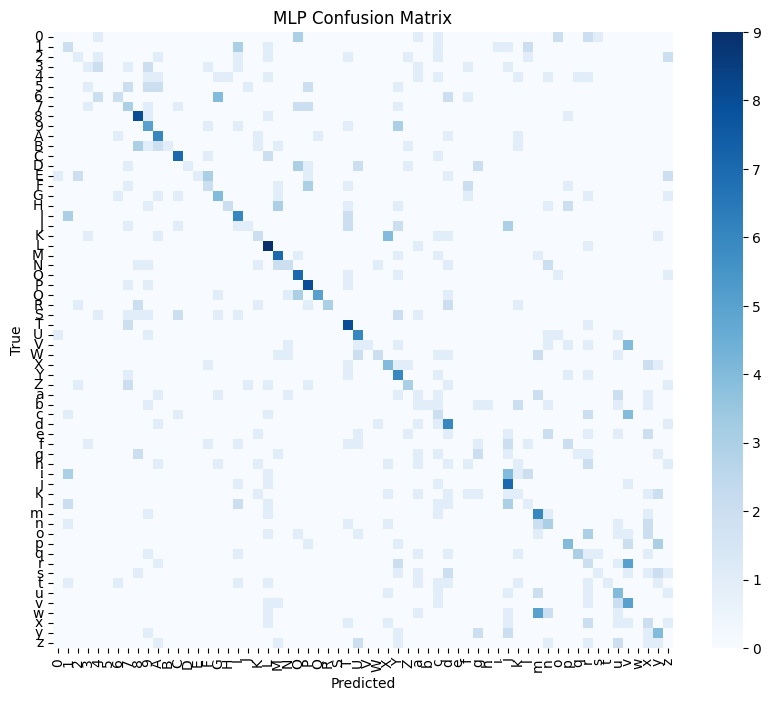

In [18]:
best_model.eval()
with torch.no_grad():
    preds = best_model(X_test_t).argmax(dim=1).numpy()

print("\nMLP Test Accuracy:", accuracy_score(y_test, preds))
print("\nClassification Report:\n", classification_report(y_test, preds, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_, annot=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("MLP Confusion Matrix")
plt.show()


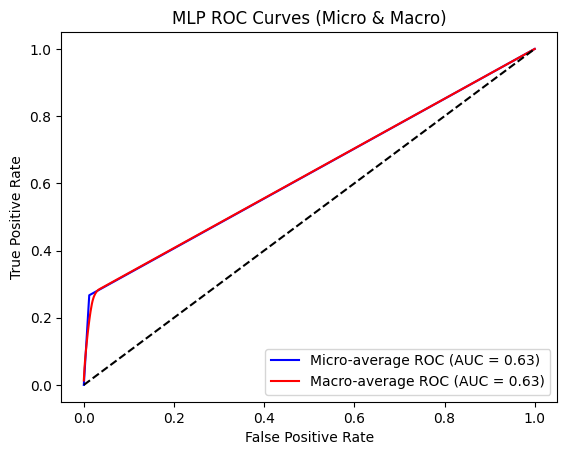

In [19]:
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
preds_bin = label_binarize(preds, classes=np.arange(len(le.classes_)))

fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), preds_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

fpr_dict, tpr_dict, roc_auc_dict = {}, {}, {}
for i in range(len(le.classes_)):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(y_test_bin[:, i], preds_bin[:, i])
    roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])

all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(len(le.classes_))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(le.classes_)):
    mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
mean_tpr /= len(le.classes_)
roc_auc_macro = auc(all_fpr, mean_tpr)

plt.figure()
plt.plot(fpr_micro, tpr_micro, label=f"Micro-average ROC (AUC = {roc_auc_micro:.2f})", color="blue")
plt.plot(all_fpr, mean_tpr, label=f"Macro-average ROC (AUC = {roc_auc_macro:.2f})", color="red")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MLP ROC Curves (Micro & Macro)")
plt.legend(loc="lower right")
plt.show()


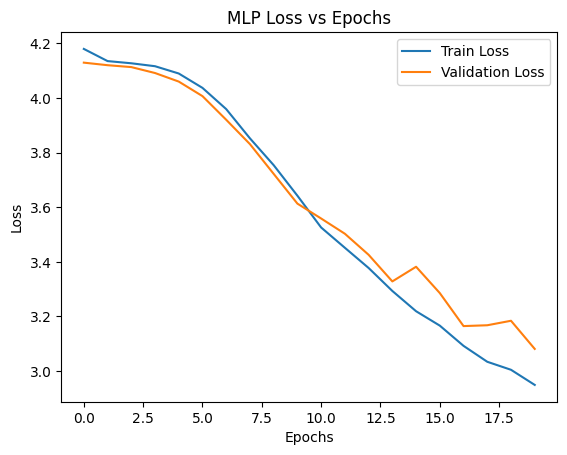

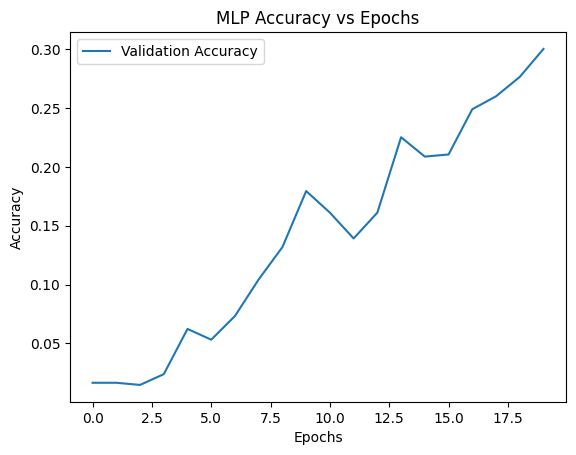

In [20]:
plt.figure()
plt.plot(best_history["train_loss"], label="Train Loss")
plt.plot(best_history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("MLP Loss vs Epochs")
plt.legend()
plt.show()

plt.figure()
plt.plot(best_history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("MLP Accuracy vs Epochs")
plt.legend()
plt.show()
